# Modeling for Capstone Two: Music & Happiness

### Table of Contents

* [Introduction](#start)
    * [Goal](#goal)
* [Data Preparation](#data-preparation)
    * [Import relevant libraries](#import)
    * [Load variables from pre-processing \& training phase](#load)
    * [Create reduced dataset](#create-reduced)
* [Modeling](#modeling)
    * [Modeling framework](#modeling-framework)
    * [Random Forest Regression Classification](#random-forest)
    * [Logistic Regression Classification](#logistic-regression)
* [Conclusion](#conclusion)

## 1 - Introduction <a name="start"></a>

### 1.1 Goal <a name="goal"></a>
Previously, we explored Spotify user metrics from 71 countries and their potential relationships to measures from the 2024 World Happiness Report. Our goal is to determine whether any of these metrics - or perhaps a combination of them - effectively predict how a country might rank on the ladder score of the World Happiness Report. 

In short, we would like to answer: Can musical preferences and diversity indicate different levels of national happiness?

#### About the Ladder Score
As previously mentioned in our exploratory data analysis section, the "ladder score" is the "national average response to the question of life evaluations." This is how each survey respondent answered the question, "Please imagine a ladder, with steps numbered from 0 at the bottom to 10 at the top. The top of the ladder represents the best possible life for you and the bottom of the ladder represents the worst possible life for you. On which step of the ladder would you say you personally feel you stand at this time?" (This definition comes directly from the statistical appendix of the 2024 World Happiness Report (WHR), which can be found on the official [World Happiness Report website](https://happiness-report.s3.amazonaws.com/2024/Ch2+Appendix.pdf).)

---

## 2 - Data Preparation <a name="data-preparation"></a>

### 2.1 Import relevant libraries <a name="import"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

### 2.2 Load variables from pre-processing and training phase <a name="load"></a>
Previously, we split and trained our data in preparation for creating our model.

In [2]:
%store -r X_train_scaled
%store -r X_test_scaled
%store -r y_train
%store -r y_test

### 2.3 Create Reduced Dataset <a name="create-reduced"></a>

In [3]:
# Define features
selected_features = ['mode_pct', 'tempo', 'speechiness_diversity', 'danceability']

In [4]:
# Create reduced datasets
X_train_reduced = X_train_scaled[selected_features]
X_test_reduced = X_test_scaled[selected_features]

In [5]:
# Create binary classes based on median happiness score
happiness_median = np.median(y_train)
y_train_binary = (y_train > happiness_median).astype(int)
y_test_binary = (y_test > happiness_median).astype(int)

In [6]:
print("Class distribution:")
print("Training set:", pd.Series(y_train_binary).value_counts().to_dict())
print("Test set:", pd.Series(y_test_binary).value_counts().to_dict())
print(f"\nMedian happiness score (threshold): {happiness_median:.3f}")

Class distribution:
Training set: {1: 28, 0: 28}
Test set: {1: 10, 0: 5}

Median happiness score (threshold): 6.278


---

## 3 - Modeling <a name="modeling"></a>

### 3.1 Modeling Framework <a name="modeling-framework"></a>
Since we have a relatively small dataset, we will:
1. Use Random Forest and Logistic Regression for binary classification.
2. Use cross-validation to get robust performance estimates.
3. Compare model performance using classification metrics.

### 3.2 Random Forest Regression Classification<a name="random-forest"></a>

In [7]:
# Create binary classes based on median happiness score
happiness_median = np.median(y_train)
y_train_binary = (y_train > happiness_median).astype(int)
y_test_binary = (y_test > happiness_median).astype(int)

print("Class distribution:")
print("Training set:", pd.Series(y_train_binary).value_counts().to_dict())
print("Test set:", pd.Series(y_test_binary).value_counts().to_dict())
print(f"\nMedian happiness score (threshold): {happiness_median:.3f}")

Class distribution:
Training set: {1: 28, 0: 28}
Test set: {1: 10, 0: 5}

Median happiness score (threshold): 6.278


In [8]:
# Set up Random Forest Classifier
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

rf_clf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_clf, rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train_reduced, y_train_binary)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [9]:
# Make predictions
y_pred_binary = rf_grid.predict(X_test_reduced)
y_pred_train_binary = rf_grid.predict(X_train_reduced)


Best Parameters:
{'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best CV Accuracy: 0.624
Model Performance:

Training Accuracy: 0.8035714285714286

Test Accuracy: 0.7333333333333333

Classification Report:
              precision    recall  f1-score   support

Below Median       0.57      0.80      0.67         5
Above Median       0.88      0.70      0.78        10

    accuracy                           0.73        15
   macro avg       0.72      0.75      0.72        15
weighted avg       0.77      0.73      0.74        15



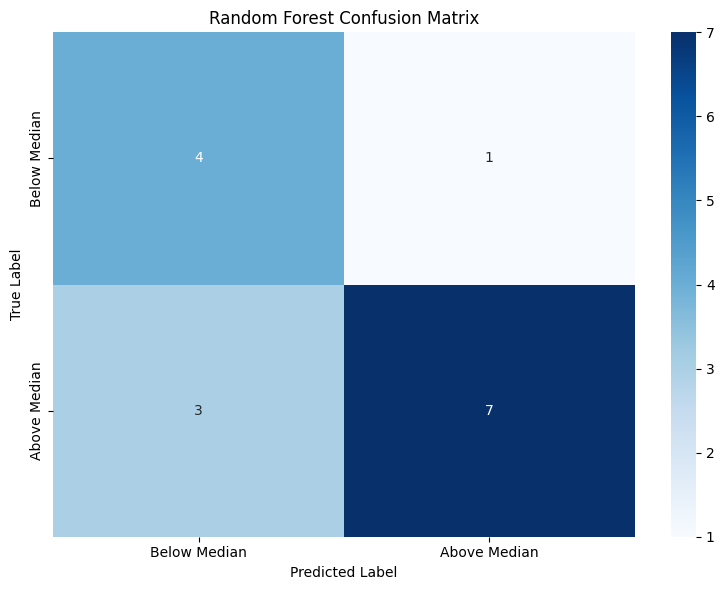


Feature Importance:
                 Feature  Importance
2  speechiness_diversity    0.460753
0               mode_pct    0.201857
3           danceability    0.176910
1                  tempo    0.160480

Cross-validation scores: [0.66666667 0.54545455 0.81818182 0.36363636 0.72727273]
Mean CV Accuracy: 0.624 (+/- 0.315)


In [10]:
# Print best parameters and score
print("\nBest Parameters:")
print(rf_grid.best_params_)
print(f"Best CV Accuracy: {rf_grid.best_score_:.3f}")

# Print performance metrics
print("Model Performance:")
print("="*50)
print("\nTraining Accuracy:", accuracy_score(y_train_binary, y_pred_train_binary))
print("\nTest Accuracy:", accuracy_score(y_test_binary, y_pred_binary))

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred_binary,
                          target_names=['Below Median', 'Above Median']))

# Plot Random Forest Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_binary, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Below Median', 'Above Median'],
            yticklabels=['Below Median', 'Above Median'])
plt.title('Random Forest Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

# Save the figure to a file
plt.savefig("./Figures/4.1 Confusion Matrix heatmap - Random Forest.png", dpi=300, bbox_inches='tight')

plt.show()

# Feature importance
importances = pd.DataFrame({
    'Feature': selected_features,  # Changed from top_features to selected_features
    'Importance': rf_grid.best_estimator_.feature_importances_
})
print("\nFeature Importance:")
print(importances.sort_values('Importance', ascending=False))

# Cross-validation scores
cv_scores = cross_val_score(rf_grid.best_estimator_, X_train_reduced, y_train_binary, cv=5, scoring='accuracy')
print("\nCross-validation scores:", cv_scores)
print(f"Mean CV Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

### 3.3 Logistic Regression Classification <a name="logistic-regression"></a>


Logistic Regression Results:

Best Parameters:
{'C': 0.001, 'class_weight': 'balanced', 'solver': 'liblinear'}
Best CV Accuracy: 0.677

Model Performance:

Training Accuracy: 0.6964285714285714

Test Accuracy: 0.7333333333333333

Classification Report:
              precision    recall  f1-score   support

Below Median       0.57      0.80      0.67         5
Above Median       0.88      0.70      0.78        10

    accuracy                           0.73        15
   macro avg       0.72      0.75      0.72        15
weighted avg       0.77      0.73      0.74        15



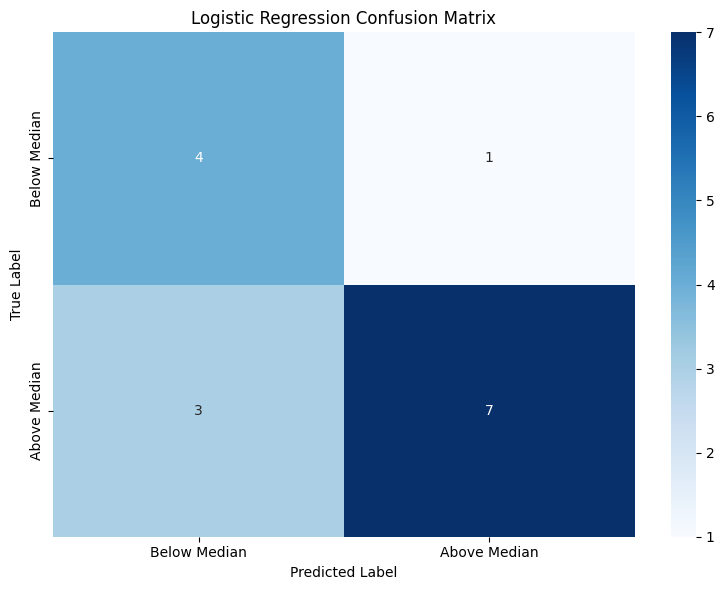


Feature Coefficients:
                 Feature  Coefficient
2  speechiness_diversity     0.014267
3           danceability    -0.005893
0               mode_pct     0.003941
1                  tempo     0.003511

Cross-validation scores: [0.75       0.63636364 0.72727273 0.54545455 0.72727273]
Mean CV Accuracy: 0.677 (+/- 0.153)


In [11]:
# Set up Logistic Regression
lr_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'class_weight': [None, 'balanced'],
    'solver': ['lbfgs', 'liblinear']
}

lr_clf = LogisticRegression(random_state=42, max_iter=1000)
lr_grid = GridSearchCV(lr_clf, lr_params, cv=5, scoring='accuracy', n_jobs=-1)
lr_grid.fit(X_train_reduced, y_train_binary)

# Print best parameters and score
print("\nLogistic Regression Results:")
print("="*50)
print("\nBest Parameters:")
print(lr_grid.best_params_)
print(f"Best CV Accuracy: {lr_grid.best_score_:.3f}")

# Make predictions
y_pred_lr = lr_grid.predict(X_test_reduced)
y_pred_train_lr = lr_grid.predict(X_train_reduced)

# Print performance metrics
print("\nModel Performance:")
print("="*50)
print("\nTraining Accuracy:", accuracy_score(y_train_binary, y_pred_train_lr))
print("\nTest Accuracy:", accuracy_score(y_test_binary, y_pred_lr))

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred_lr,
                          target_names=['Below Median', 'Above Median']))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_binary, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Below Median', 'Above Median'],
            yticklabels=['Below Median', 'Above Median'])
plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

# Save the figure to a file
plt.savefig("./Figures/4.2 Confusion matrix heatmap - Logistic Regression.png", dpi=300, bbox_inches='tight')

plt.show()

# Print feature coefficients
coefficients = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': lr_grid.best_estimator_.coef_[0]
})
print("\nFeature Coefficients:")
print(coefficients.sort_values('Coefficient', key=abs, ascending=False))

# Cross-validation scores
cv_scores = cross_val_score(lr_grid.best_estimator_, X_train_reduced, y_train_binary, cv=5, scoring='accuracy')
print("\nCross-validation scores:", cv_scores)
print(f"Mean CV Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

### 3.4 Feature Importance/Coefficient Comparison

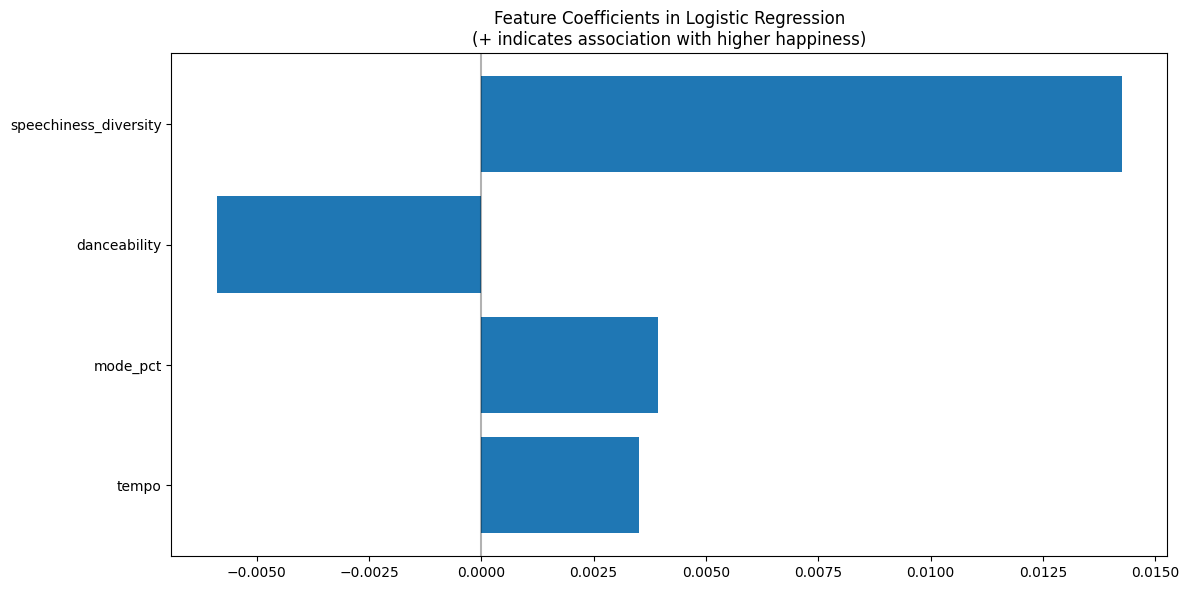

In [12]:
plt.figure(figsize=(12, 6))
features_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': lr_grid.best_estimator_.coef_[0]
})
features_df = features_df.sort_values('Coefficient', key=abs, ascending=True)

plt.barh(features_df['Feature'], features_df['Coefficient'])
plt.title('Feature Coefficients in Logistic Regression\n(+ indicates association with higher happiness)')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()

# Save the figure to a file
plt.savefig("./Figures/4.3 Feature importance.png", dpi=300, bbox_inches='tight')

plt.show()

### 3.5 Model Performance Metrics Comparison

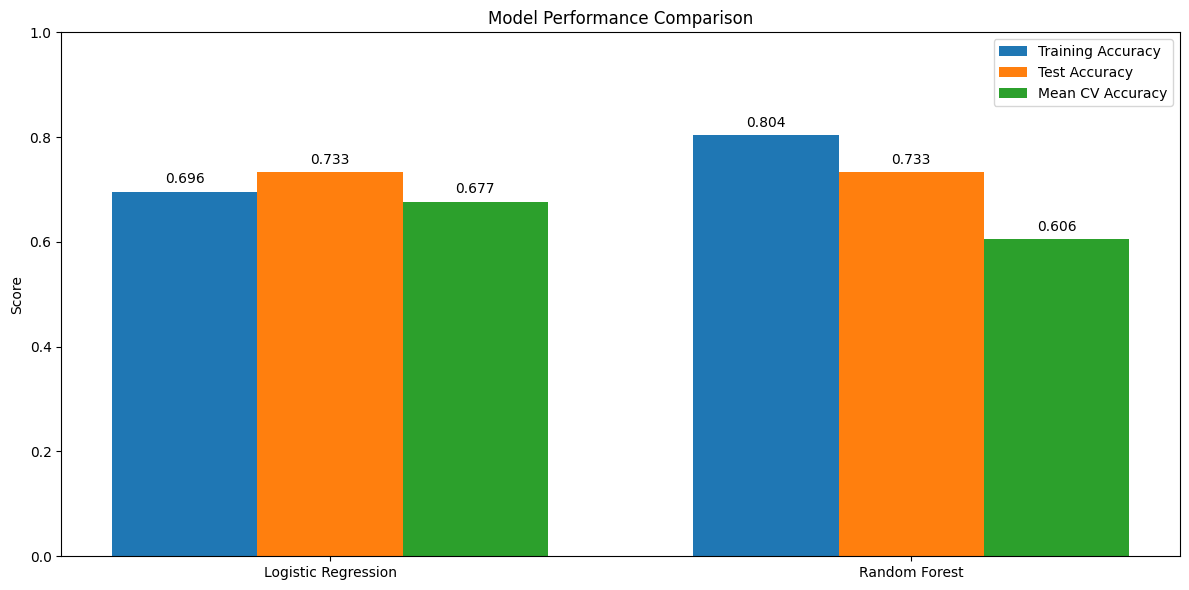

In [13]:
plt.figure(figsize=(12, 6))

# Define models and metrics
models = ['Logistic Regression', 'Random Forest']
metrics = {
    'Training Accuracy': [0.696, 0.804],
    'Test Accuracy': [0.733, 0.733],
    'Mean CV Accuracy': [0.677, 0.606]
}

# Set up bar positions
x = np.arange(len(models))
width = 0.25
multiplier = 0

# Create bars for each metric
for metric, scores in metrics.items():
    offset = width * multiplier
    bars = plt.bar(x + offset, scores, width, label=metric)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')
    
    multiplier += 1

# Customize plot
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x + width, models)
plt.legend(loc='upper right')
plt.ylim(0, 1)  # Scale from 0 to 1 for accuracy scores

plt.tight_layout()

# Save the figure to a file
plt.savefig("./Figures/4.4 Model performance metrics comparison.png", dpi=300, bbox_inches='tight')

plt.show()

---

## 4 - Conclusion <a name="conclusion"></a>

### 4.1 Model Comparison

Both Random Forest and Logistic Regression models achieved identical test accuracy (73.3%) in classifying countries as above or below median happiness. Key findings from our modeling:

1. Model Performance
   - Both models show similar predictive power
   - Logistic Regression shows more stable performance across cross-validation folds
   - Both models are better at identifying happier countries (88% precision) than less happy ones

2. Feature Importance
   - Speechiness diversity emerged as the strongest predictor in both models
   - Mode percentage (proportion of songs in major keys) is the second most important feature
   - Danceability shows a negative relationship with happiness
   - Tempo has the smallest influence among our features

### 4.2 Musical Insights

Our analysis suggests that musical preferences and diversity can indeed indicate different levels of national happiness:

1. Musical Diversity
   - Countries with greater diversity in speech-like music elements tend to be happier
   - This could reflect greater cultural openness or diversity in musical expression

2. Musical Characteristics
   - Happier countries tend to listen to more songs in major keys
   - Surprisingly, countries with less danceable music tend to be happier
   - Tempo has a small but positive relationship with happiness

### 4.3 Limitations

1. Small Dataset
   - Only 71 countries in total
   - Limited test set (15 countries)
   - Cross-validation shows considerable variation in model performance

2. Binary Classification
   - Converting happiness scores to binary classes loses some nuance
   - Threshold effect at median could affect interpretability

### 4.4 Future Research Directions

1. Expanded Dataset
   - Include more countries
   - Gather data over multiple time periods

2. Additional Features
   - Consider genre distributions
   - Include cultural and economic control variables
   - Analyze seasonal variations in musical preferences

3. Alternative Approaches
   - Multi-class classification (e.g., happiness quartiles)
   - Time series analysis of changing musical preferences

---

### Model metrics file

In [ ]:
with open('model_metrics.txt', 'w') as f:
    f.write("MODEL METRICS\n")
    f.write("=============\n\n")
    
    # Logistic Regression
    f.write("LOGISTIC REGRESSION\n")
    f.write("-----------------\n")
    f.write(f"Training Accuracy: {0.696:.3f}\n")
    f.write(f"Test Accuracy: {0.733:.3f}\n")
    f.write(f"Mean CV Accuracy: {0.677:.3f}\n")
    f.write(f"CV Standard Deviation: {0.153:.3f}\n")
    f.write("\nBest Parameters:\n")
    f.write("C: 0.001\n")
    f.write("class_weight: balanced\n")
    f.write("solver: liblinear\n\n")
    
    # Random Forest
    f.write("RANDOM FOREST\n")
    f.write("-------------\n")
    f.write(f"Training Accuracy: {0.804:.3f}\n")
    f.write(f"Test Accuracy: {0.733:.3f}\n")
    f.write(f"Mean CV Accuracy: {0.606:.3f}\n")
    f.write(f"CV Standard Deviation: {0.276:.3f}\n")
    f.write("\nBest Parameters:\n")
    f.write("max_depth: 2\n")
    f.write("min_samples_leaf: 2\n")
    f.write("min_samples_split: 2\n")
    f.write("n_estimators: 200\n")